## Integrantes
<ul>
<li>Sebastián Aranda 201104560-2</li>
<li>Felipe Santander 201104528-9</li>
</ul>

# Fronteras de Clasificación

A continuación se presenta un dataset sintético en 2 Dimensiones donde la frontera de clasificación para ambos conjuntos de datos no es lineal.
Se agrega un parámetro de ruido para ir variando la instancia de clasificación y así analizar el comportamiento de distintas Fronteras de Clasificación.

In [34]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

##### Manifold
Producido desde dos distribuciones:
<ul>
<li>Distribución multivariada gaussiana</li>
<li>Funciones senos y cosenos</li>
</ul>

Para cada distribución se generan 500 ejemplos.

Shape Datos1:  (500, 2)
Shape Datos2:  (500, 2)


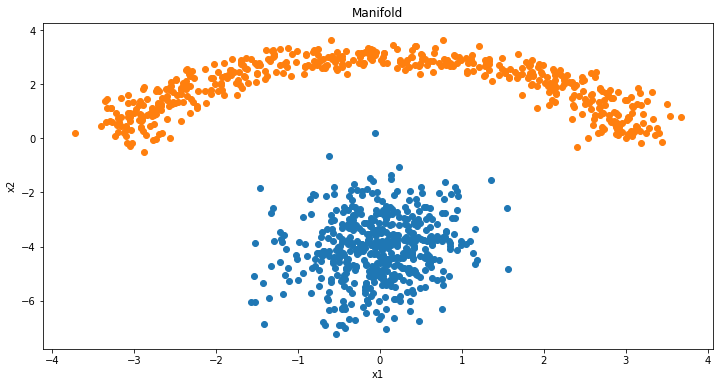

In [51]:
n_samples=500

#Generating Multivariate Normal Distribution
mean = (0,-4)
#mean = (0,-3)
#mean = (0,-2)
#mean = (0,-1)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
datos1 = np.random.multivariate_normal(mean, C, n_samples)

#Generating Halfmoon Distribution
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T
generator = check_random_state(10)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

print "Shape Datos1: ", datos1.shape
print "Shape Datos2: ", datos2.shape

x1,y1 = datos1.T
x2,y2 = datos2.T

plt.figure(figsize=(12,6))
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.title("Manifold")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

A continuación se agrega un parámetro de ruido para agregar más complejidad de clasificación al conjunto de datos. Según la magnitud de ruido escogida se realiza un shift de datos desde un conjunto a otro.

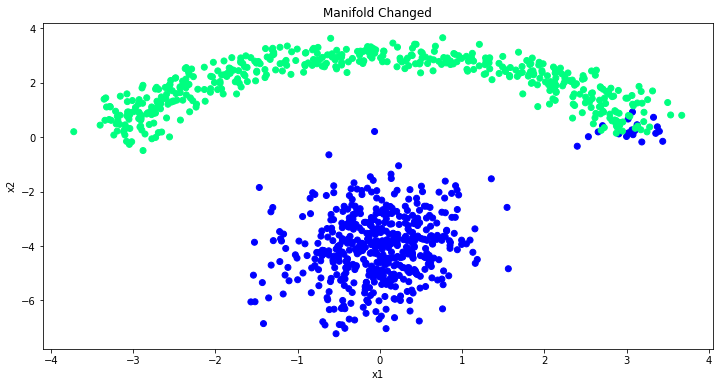

Dataset 1 Size: 520
Dataset 2 Size: 480


In [54]:
X = np.concatenate((datos1, datos2), axis=0)
#y = [i%2 for i in range(len(datos1)+len(datos2))] #No linear separable

n = 20 #Noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

plt.figure(figsize=(12,6))
plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.winter)
plt.title("Manifold Changed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print "Dataset 1 Size:", len(y1)
print "Dataset 2 Size:", len(y2)

A continuación se presentan las fronteras de clasificación de dos modelos generativos LDA y QDA junto al Widget Interactive con el que se puede variar el parámetro de ruido para apreciar como se comportan ambos algoritmos. 

Al jugar con distintos valores de medias para la distribución multivariada gaussiana, y al ir variando el hiper-parámetro de ruido, se puede apreciar muy gráficamente como transformándose las frontera de decisión.

In [55]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix

def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

    
def visualize_border_interactive_noise(noise):
    y1 = np.zeros(datos1.shape[0]+noise)
    y2 = np.ones(datos2.shape[0]-noise)
    y = np.concatenate((y1,y2),axis=0)
    
    mTest_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=mTest_size, random_state=0)
    
    model_lda = LDA()
    model_qda = QDA()
        
    model_lda.fit(X_train,y_train)
    model_qda.fit(X_train,y_train)
    
    visualize_border(model_lda,X,y,"LDA trained with %.2f"%(1-mTest_size)+" of the data")
    visualize_border(model_qda,X,y,"QDA trained with %.2f"%(1-mTest_size)+" of the data")
    
    y_pred_lda = model_lda.predict(X_test)
    y_pred_qda = model_qda.predict(X_test)
    
    print("Miss Classification Loss of LDA: %.2f"%(1-accuracy_score(y_test, y_pred_lda)))
    print("Miss Classification Loss of QDA: %.2f"%(1-accuracy_score(y_test, y_pred_qda)))
    
    print("Confusion Matrix of LDA")
    print(confusion_matrix(y_test, y_pred_lda))
    print("Confusion Matrix of QDA")
    print(confusion_matrix(y_test, y_pred_qda))
    
interactive(visualize_border_interactive_noise,noise=(0,500))

##### LDA
En Linear Discriminant Analysis (LDA) se construye una frontera de clasificación lineal modelando las densidades de las clases:

\begin{equation}
f_k(x) = P(G=k|X=x) = E(Y_k|X)
\end{equation}

En otras palabras, se define la densidad de clases como $f_k(x)$ correspondiente a la densidad condicional de $X$ dado $G = k$. Eesta densidad utilizando una Distribución Multivariada Gaussiana (DMG):

\begin{equation}
f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}
\end{equation}

En particular LDA asume que las clases poseen la misma matriz de covarianza, es decir $\Sigma_k=\Sigma \quad \forall k$. Gracias a esta suposición la comparación de dos clases $k$ y $l$ resulta en una ecuación lineal en $x$ y $p$ al utilizar log-ratio:

\begin{equation}
\begin{split}
log\frac{P(G=k|X=x)}{P(G=l|X=x)}&=log\frac{f_k(x)}{f_l(x)}log\frac{\pi_k}{\pi_l}\\
&=log\frac{\pi_k}{\pi_l}-\frac{1}{2}(\mu_k+\mu_l)^T\Sigma^{-1}(\mu_k-\mu_l)\\
&\quad+x^T\Sigma^{-1}(\mu_k-\mu_l)
\end{split}
\end{equation}

Siendo las funciones discriminantes:

\begin{equation}
\delta_k(x) = x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+log\pi_k
\end{equation}

##### QDA
Para el caso de Quadratic Discriminant Analysis (QDA), el proceso para generar la frontera de clasificación es el mismo excepto que no se realiza la suposición de que las matrices de covarianza de las clases son iguales, aquí se asumen distintas y por lo tanto no se eliminan los términos cuadráticos de la ecu, quedando las funciones discriminantes:

\begin{equation}
\delta_k(x) = -\frac{1}{2}log|\Sigma_k|-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)+log\pi_k
\end{equation}

##### Análisis Cuantitativo LDA vs QDA

En términos cuantitativos, y para este dataset, uno esperaria que QDA tuviese un menor error de predicción debido a que su frontera de clasificación es cuadrática, y en el dataset propuesto se aprecia claramente que la frontera de separación es cuadrática. En general QDA y LDA se comportan similar en capacidad de predicción, sin embargo si se utilizara otro valor de medias para la distribución multivariada gaussiana, por ejemplo $mean=(0,-4)$, de tal manera de acortar la separación entre ambos datasets, se puede apreciar cómo cambia el error de clasificación y QDA se presenta como un mejor candidato para obtener un bajo error de predicción

##### Logistic Regression, SVM, Classification Tree & KNN

En la presente sección se analizarán los parámetros de regularización para distintos algoritmos de clasificación. 

In [77]:
mTest_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=mTest_size, random_state=0)

In [78]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)
    y_pred = model.predict(X_test)
    print("Miss Classification Loss: %.2f"%(1-accuracy_score(y_test, y_pred)))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

El parámetro de regularización en regresión logística tiene como fin evitar que los pesos del modelo se ajusten al ruido, es decir evitar over-fitting, por lo que mientras más ruido más regularizacion se va a necesitar. 

Se puede apreciar al variar el valor del parámetro C (inverso del parámetro de regularización) que para valores muy pequeños, es decir regularización muy alta, la frontera de clasificación considera en un menor grado a los datos que son ruido.

In [79]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X_train,y_train)
    return model

p_min = 0.0000000001 #define your range
p_max = 10000000000 #define your range
step = 0.01
interactive(visualize_border_interactive,param=(p_min,p_max,step))

Para SVM con kernel lineal se presenta un comportamiento similar al caso anterior, sin embargo se puede apreciar que el movimiento de la frontera es una traslación en el eje x2, mientras que la frontera de Logistic Regression representa una inclinación o rotación.

In [80]:
from sklearn.svm import SVC as SVM
#SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X_train,y_train)
    return model

p_min = 0.0000000001 #define your range
p_max = 10000000000 #define your range
step = 0.1
interactive(visualize_border_interactive,param=(p_min,p_max,step))

SVM con kernel RBF presenta una frontera de clasificación cuadrática y como se puede apreciar al igual que en los casos anteriores, al tener un mayor parámetro de regularización (menor valor de C) para considerar en menor grado el ruido del dataset. 

In [71]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X_train,y_train)
    return model

p_min = 0.0000000001 #define your range
p_max = 10000000000 #define your range
step = 0.01
interactive(visualize_border_interactive,param=(p_min,p_max,step))

El comportamiento de SVM con kernel polinomial presenta ciertas variaciones en la curva de clasificación al ir variando el parámetro inverso del parámetro de regularización. Los resultados en términos cuantitativos son muy similares a los obtenidos por SVM con kernel linear y RBF.

In [74]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X_train,y_train)
    return model

p_min = 0.0000000001 #define your range
p_max = 10000000000 #define your range
step = 0.01
interactive(visualize_border_interactive,param=(p_min,p_max,step))

Mientras mas profundidad tenga el arbol (aumento de paramentro de regularizacion) mayor sera el over-fitting.

In [75]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model = Tree()#edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 30 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Mientras menor es el parametro de regularizacion mayor será el over-fitting, en caso contrario la frontera de decision sera mas suave en el espacio de caracteristicas.

In [76]:
from sklearn.neighbors import KNeighborsClassifier
def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 50 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

# Análisis de Audio - Datos Brutos

### <a href="https://www.kaggle.com/kinguistics/heartbeat-sounds">Heartbeat-sounds Kaggle</a>

A continuación se realizará un procesamiento de datos crudos para luego poder realizar tareas de clasificación con distintos algoritmos como Logistic Regression, SVM y Decision Trees. Dentro del trabajo de procesamiento de datos crudos se utiliza una herramienta de reducción de dimensionalidad llamada PCA.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

In [83]:
df = pd.read_csv('./heartbeat-sounds_dataset/set_a.csv')
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [84]:
df['label'].value_counts(dropna=False)

NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

A continuación se realiza un "padd de ceros", en otras palabras se estandariza la dimensionalidad de las series de tiempo ya que en principio poseen distintos largos. Este paso es importante porque más adelante el espacio de características (X) estará conformado por estas series de tiempo, y por tanto deben poser la misma cantidad de columnas $(p+1)$, considerando el intercepto. 

In [85]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='heartbeat-sounds_dataset/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
print("DataFrame Edit Ok")

DataFrame Edit Ok


### <a href="https://www.kaggle.com/toregil/new-labels-for-set-a">New labels for set a</a>

En el siguiente paso se realiza un ajuste en las etiquetas de los datos, ahora provistas por la opinión de un experto. Este paso se realiza con el objetivo de mejorar la capacidad de predicción del modelo incorporando conocimiento experto.

In [86]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
             1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
             2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

In [87]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [88]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

Del bloque de código anterior se obtiene la dimensionalidad de $X$. Se puede apreciar que la cantidad de columnas es casi 400.000. Si no se realiza algún tipo de pre procesmiento el algoritmo se volvera extremádamente complejo y se verá afectado por "La Maldición de la Dimensionalidad", cayendo por tanto en overfiting. Para solucionar este problema, se procesa la secuencia de tiempo utilizando una <a href="https://en.wikipedia.org/wiki/Fourier_transform">transformada de fourier discreta</a> para pasar los datos desde el dominio de tiempos al de frecuencias, presentes en la señal de sonido; de esta manera se reduce la dimensionalidad considerablemente.

In [89]:
from scipy import signal

X_fourier = np.abs(np.fft.fft(X))

X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)

X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

Del bloque de código anterior se aprecia una reducción del orden de un 75%, reduciendo de esta manera el efecto de la "maldición de la dimensionalidad".

##### Hold-out Validation

A continuación se realiza una seperación del dataset en un conjunto de entrenamiento y otro de testeo, además se realiza una estandarización de los datos, paso muy importante ya que PCA asume que la media de los datos es 0 y por esto se debe ajustar el conjunto de entrenamiento.

X_train.shape:  (132, 100000)


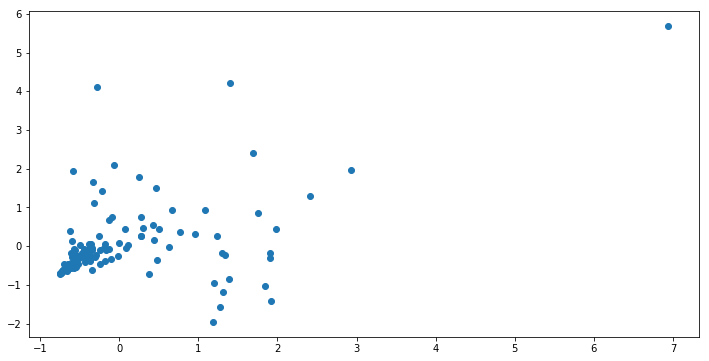

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

#Standarization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
std.fit(X_test)
X_test = std.transform(X_test)

print "X_train.shape: ", X_train.shape
plt.figure(figsize=(12,6))
plt.scatter(X_train[:,0],X_train[:,1], cmap=plt.cm.winter)
plt.show()

Se realiza una reducción de dimensionalidad con PCA para quedar solo con 2 dimensiones.

PCA X_train.shape:  (132, 2)


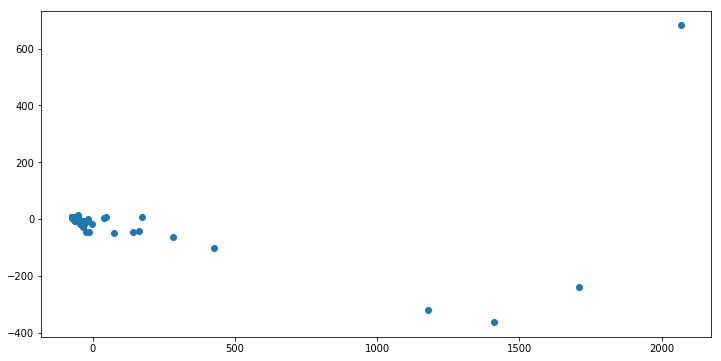

In [100]:
#PCA
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

print "PCA X_train.shape: ", X_pca_train.shape
plt.figure(figsize=(12,6))
plt.scatter(X_pca_train[:,0], X_pca_train[:,1], cmap=plt.cm.winter)
plt.show()

Se construyen gráficos de error de entrenamiento y testeo en función del hiper-parámetro de regularización C para un modelo de Regresión Logística y para otro de SVM con kernel lineal. Se puede apreciar que existe una diferencia en los algoritmos en un principio, cuando el parámetro C es bajo, es decir, cuando estamos ejerciendo una alta regularización. Cerca del orden de $10^2$ los errores de clasificación de testeo de ambos algoritmos comienzan a converger hacia un valor de alrededor de 52%

Logistic Regression Error's Plot


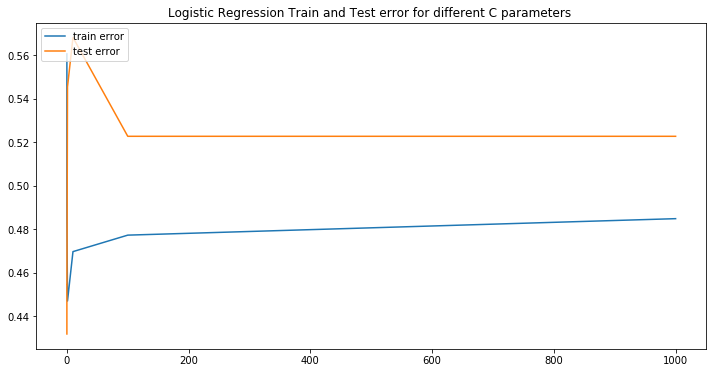

SVM Error's Plot


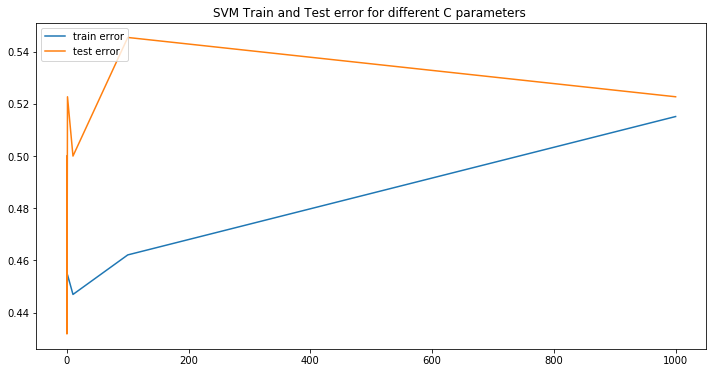

In [106]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_pca_train,y_train)
    y_pred_train = model.predict(X_pca_train)
    y_pred_test = model.predict(X_pca_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_pca_train,y_train)
    y_pred_train = model.predict(X_pca_train)
    y_pred_test = model.predict(X_pca_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Respecto al árbol de decisión utilizado se nota según el gráfico presentado a continuación, que el error de testeo se mantiene en un rango de valores acotado y además alternante entre estos valores. Efecto que puede ser descrito debido a la fineza con la que se construyen las regiones de split en estos árboles. En cuanto al error de entrenamiento se nota una disminución clara a medida que aumentamos el parámetro de regularización C.

Decision Tree Error's Plot


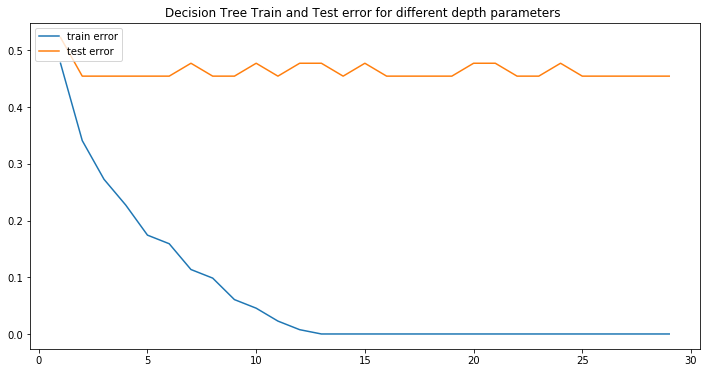

In [107]:
from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_pca_train,y_train)
    y_pred_train = model.predict(X_pca_train)
    y_pred_test = model.predict(X_pca_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Experimente con diferentes dimensiones <i>d</i> para la proyección de PCA con el propósito de obtener un modelo con menor error. Construya una tabla o grafico resumen

A continuación se realiza otra reducción de dimensionalidad, ahora a través de la técnica LDA.

LDA X_train.shape:  (132, 2)


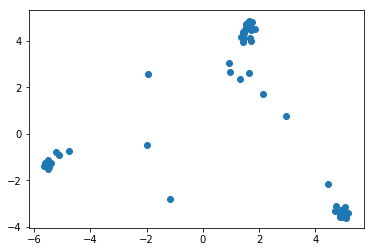

In [108]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_lda_train = model_lda.transform(X_train)
X_lda_test = model_lda.transform(X_test)

print "LDA X_train.shape: ", X_lda_train.shape
plt.figure()
plt.scatter(X_lda_train[:,0], X_lda_train[:,1])
plt.show()

Ahora se presenta una comparación de los errores de entrenamiento y testeo utilizando el conjunto de características descrito por LDA. De los gráficos presentados a continuación se observa una clara tendencia de variación para valores muy pequeños de C, es decir, con alta regularización. Para valores de C del orden de 10̣ en adelante tanto SVM como Regresión Logística poseen un error de clasificación constante y cercano al 52%.

Logistic Regression Error's Plot


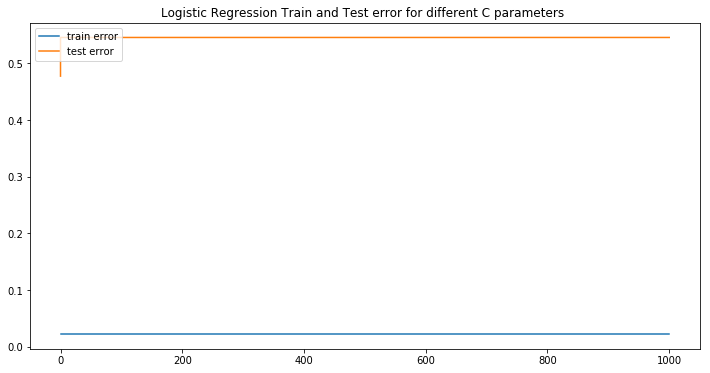

SVM Error's Plot


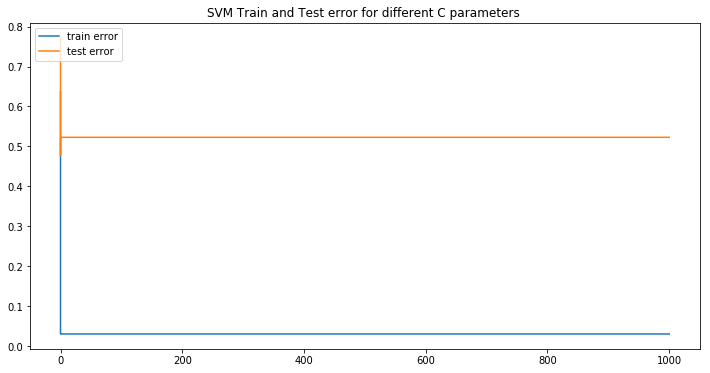

In [109]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_lda_train,y_train)
    y_pred_train = model.predict(X_lda_train)
    y_pred_test = model.predict(X_lda_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_lda_train,y_train)
    y_pred_train = model.predict(X_lda_train)
    y_pred_test = model.predict(X_lda_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Decision Tree Error's Plot


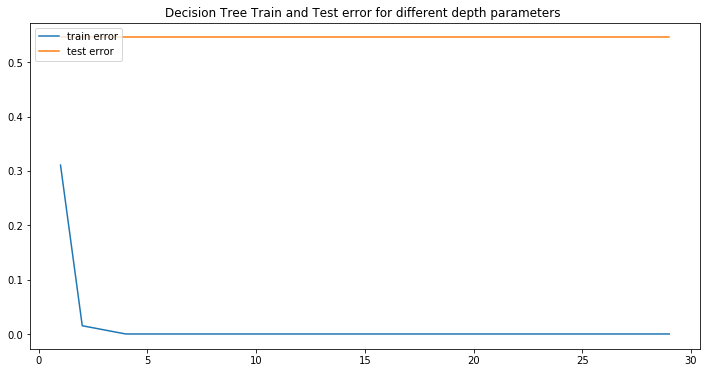

In [110]:
from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_lda_train,y_train)
    y_pred_train = model.predict(X_lda_train)
    y_pred_test = model.predict(X_lda_test)
    e_train.append(1-accuracy_score(y_pred_train,y_train))
    e_test.append(1-accuracy_score(y_pred_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

##### Feature Crafting

### <a href="https://www.kaggle.com/primaryobjects/voicegender">Voice Classification</a>

# Análisis de Emociones - Twitter

<a href="https://www.crowdflower.com/data-for-everyone/">Crowd Flower</a>

Se carga el archivo como dataframe de la libreria pandas, de este archivo se extraen las clases existentes que son el objetivo que deberán predecir los modelos de clasificación que se utilizarán en esta parte de la tarea. Se tiene que el archivo consiste de 40.000 tweets que han sido catalogados como uno de entre las 13 emociones posibles: 'empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'. La etiqueta 'content' corresponde al texto de los tweets mientras que author son quienes los envian, ambos son menores a la cantidad total de tweets posiblemente a que existen tweets con el mismo texto y multiples autores responsables de mas de 1 solo tweet.

In [48]:
import pandas as pd
file_path = './text_emotion.csv'
df = pd.read_csv(file_path)
descripcion = df.apply(lambda x: len(x.unique()))
sentimientos = df.sentiment.unique()
print sentimientos
print descripcion

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']
tweet_id     40000
sentiment       13
author       33871
content      39827
dtype: int64


Se implementa un pre-procesamiento para los tweets, de modo de dejarlos en un formato estándarizado para luego ser trabajados. El pre-procesamiento implementado consiste en eliminar links, convertir todo el texto a minúscula y eliminar números dado que se estima que estos no aportan información relevante, se eliminan los signos y puntuaciones. Utilizando la libreria de nltk se obtienen los stopwords del inglés y estos son eliminados ya que son repetitivos en todos los textos (palabras como 'for', 'of', 'are', 'the', etc), luego se pasa a 'Lemmatisation' que consiste en transformar todas las palabras a su forma básica utilizando un diccionario, esto convierte palabras como 'produce' y 'produced' a 'produce'.
Alfinal del pre-procesamiento se obtiene la columna 'content_pre' el cual contiene el texto pre-procesado, la columna 'sentiment_bi' que representa la polaridad de la emocion (-1 y 1), y finalmente 'sentiment_cod' el cual tiene las 13 emociones codificadas del 0 al 12.

In [51]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import HTMLParser
df["content_pre"] = ""
stop = stopwords.words('english')
puncts = ".,:;?!()[]{}~+-\"\'#$%&"
tt = TweetTokenizer(strip_handles=True)
ps = PorterStemmer()
wd = WordNetLemmatizer()
html_parser = HTMLParser.HTMLParser()
df["sentiment_bi"] = 0
negativos = ['surprise', 'empty', 'sadness', 'worry', 'hate', 'boredom', 'anger']
positivos = ['neutral', 'enthusiasm', 'love', 'fun', 'happiness', 'relief']
df["sentiment_cod"] = 0
sentimientos_cod = {key: value for (value, key) in enumerate(sentimientos)}
for row, col in df.iterrows():
    content = df.loc[row, "content"]
    
    #Eliminando links, parseando tags html, pasando a minusculas y eliminando numeros
    #content = html_parser.unescape(content)
    content = re.sub(r"http\S+", "", content)
    content = content.lower().replace('\d+', '')
    
    #Eliminando signos y puntuaciones
    for sym in puncts:
        content = content.replace(sym, ' ')
        
    #Eliminando Stopwords
    content = ' '.join([word for word in content.split() if word not in stop])
    
    #Tokenizando
    content = tt.tokenize(content)
    
    #Stemming
    #content = [ps.stem(word) for word in content]
    
    #Lemmatisation
    content = [wd.lemmatize(word) for word in content]
    
    content = ' '.join([word for word in content])
    
    #Guardar en columna "content_pre"
    df.set_value(row, "content_pre", content)
    
    sentimiento = df.loc[row, "sentiment"]
    if sentimiento in negativos:
        df.loc[row, "sentiment_bi"] = -1
    else:
        df.loc[row, "sentiment_bi"] = 1
    
    #i
    df.loc[row, "sentiment_cod"] = sentimientos_cod.get(sentimiento)
    
df["sentiment_bi"].astype(int)

C:\Users\Paralizis\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:32: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


0       -1
1       -1
2       -1
3        1
4        1
5       -1
6       -1
7       -1
8       -1
9       -1
10       1
11      -1
12      -1
13      -1
14      -1
15      -1
16       1
17      -1
18      -1
19      -1
20      -1
21       1
22       1
23      -1
24      -1
25      -1
26      -1
27      -1
28      -1
29      -1
        ..
39970    1
39971    1
39972    1
39973    1
39974    1
39975   -1
39976    1
39977   -1
39978   -1
39979   -1
39980    1
39981    1
39982    1
39983    1
39984   -1
39985    1
39986    1
39987    1
39988    1
39989    1
39990    1
39991    1
39992    1
39993    1
39994    1
39995    1
39996    1
39997    1
39998    1
39999    1
Name: sentiment_bi, dtype: int32

Las emociones negativas son: 'surprise', 'empty', 'sadness', 'worry', 'hate', 'boredom', 'anger'
Las emociones positivas son: 'neutral', 'enthusiasm', 'love', 'fun', 'happiness', 'relief'.
Notar que se decidio dejar la emocion neutral dentro de las positivas con el fin de equilibrar la cantidad de clases en el conjunto de datos.

In [52]:
print df.iloc[:30,4:-1]

                                          content_pre  sentiment_bi
0   know listenin bad habit earlier started freaki...            -1
1             layin n bed headache ughhhh waitin call            -1
2                      funeral ceremony gloomy friday            -1
3                               want hang friend soon             1
4               want trade someone houston ticket one             1
5                   pinging go prom bc bf like friend            -1
6   sleep im thinking old friend want married damn...            -1
7                                                hmmm            -1
8                                  charlene love miss            -1
9                                  sorry least friday            -1
10                                   cant fall asleep             1
11                                    choked retainer            -1
12                 ugh beat stupid song get next rude            -1
13  u watch hill london u realise tourture week 

Con el dataframe actualizado se construyen los conjuntos de entrenamiento y de pruebas

In [53]:
import numpy as np
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

Con el dataframe pre-procesado es posible convertir el texto de los tweets en un vector de características, para ello se utiliza TfidfVectorizer el cual al igual que CountVectorizer cuenta la cantidad de repeticiones de las palabras en todos los texto (Tf: Term frequency), además asigna un 'score' a la palabra según la cantidad de veces que se repite en todos los texto, las palabras con menor repetición tendrán un 'score' aumentado ya que esto implica que son mas significativas para la clasificación, en cambio las palabras con mayor repetición tendran un 'score' reducido (idf: Inverse document frequency).<br>
Se utilizan 5 clasificadores para la clasificacion binaria de los datos, estos son: Multinomial Naive Bayes, Regresión logística, SVM, LinearSVM y Arboles de decisión.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
# feature extraction
#TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2)) #TfidfVectorizer(min_df = 3)  
train_X_tfidf = vectorizer.fit_transform(df_train.content_pre)
test_X = vectorizer.transform(df_test.content_pre)
train_y = df_train.sentiment_bi
test_y = df_test.sentiment_bi

# #############################################################################
#Clasificadores
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

#Multinomial Naive Bayes
clf_mnb = MultinomialNB().fit(train_X_tfidf, train_y)
clf_score_train = clf_mnb.score(train_X_tfidf, train_y)
clf_score_test = clf_mnb.score(test_X, test_y)
print 'Multinomial Naive Bayes score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Regresion logística
clf_logreg = LogisticRegression().fit(train_X_tfidf, train_y)
clf_score_train = clf_logreg.score(train_X_tfidf, train_y)
clf_score_test = clf_logreg.score(test_X, test_y)
print 'Regresion logística score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#SVM
clf_svc = SVC().fit(train_X_tfidf, train_y)
clf_score_train = clf_svc.score(train_X_tfidf, train_y)
clf_score_test = clf_svc.score(test_X, test_y)
print 'SVC score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Linear SVM
clf_lsvc = LinearSVC().fit(train_X_tfidf, train_y)
clf_score_train = clf_lsvc.score(train_X_tfidf, train_y)
clf_score_test = clf_lsvc.score(test_X, test_y)
print 'Linear SVC score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

#Arboles de decisión
clf_ad = DecisionTreeClassifier().fit(train_X_tfidf, train_y)
clf_score_train = clf_ad.score(train_X_tfidf, train_y)
clf_score_test = clf_ad.score(test_X, test_y)
print 'Arboles de decisión score: Train: {} Test: {}'.format(clf_score_train, clf_score_test)

Multinomial Naive Bayes score: Train: 0.761609907121 Test: 0.694254019693
Regresion logística score: Train: 0.77108546768 Test: 0.701483235697
SVC score: Train: 0.544610188573 Test: 0.540321575471
Linear SVC score: Train: 0.79529036495 Test: 0.680543437617
Arboles de decisión score: Train: 0.983050317416 Test: 0.627072167518


In [55]:
from sklearn.metrics import accuracy_score
def data_size_response(model,trX,teX,trY,teY,n_subsets=20):
    train_errs,test_errs = [],[]
    subset_sizes = np.exp(np.linspace(3,np.log(trX.shape[0]),n_subsets)).astype(int)
    for m in subset_sizes:
        model.fit(trX[:m],trY[:m])
        train_err = model.score(trX[:m], trY[:m])
        test_err = model.score(teX, teY)
        #print "training error: %.3f test error: %.3f subset size: %.3f" % (train_err,test_err,m)
        train_errs.append(train_err)
        test_errs.append(test_err)
    return subset_sizes,train_errs,test_errs

def plot_response(subset_sizes,train_errs,test_errs):
    plt.plot(subset_sizes,train_errs,lw=2)
    plt.plot(subset_sizes,test_errs,lw=2)
    plt.legend(['Score de entrenamiento','Score de test'])
    plt.xscale('log')
    plt.xlabel('Tamanio dataset')
    plt.ylabel('Score')
    plt.title('Score de entrenamiento vs Score de test')
    plt.show()


In [58]:
#ref http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Clasificador: Multinomial Naive Bayes


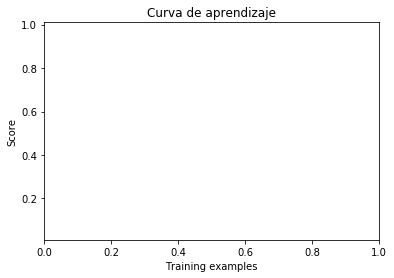

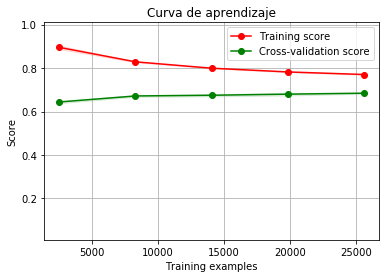

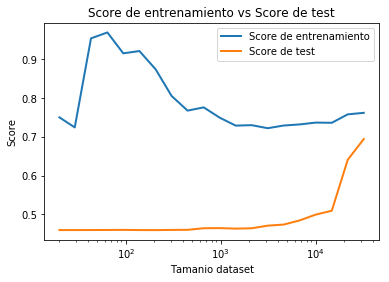

---------------------------------------------------
Clasificador: Logistic Regression


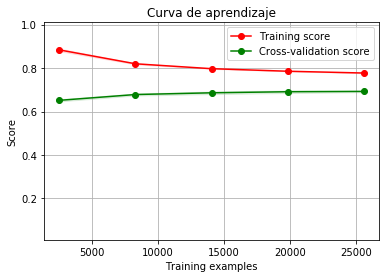

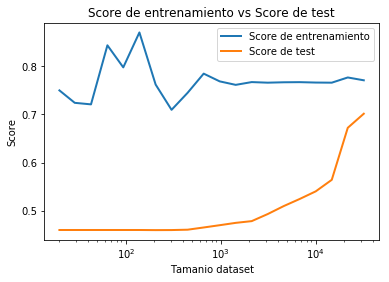

---------------------------------------------------
Clasificador: SVM


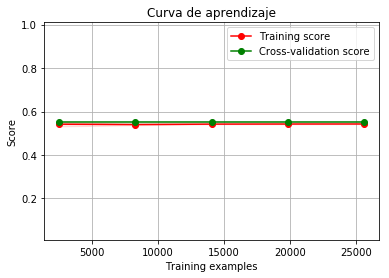

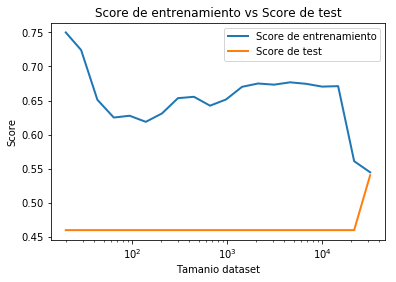

---------------------------------------------------
Clasificador: Linear SVM


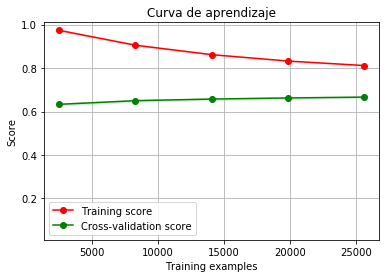

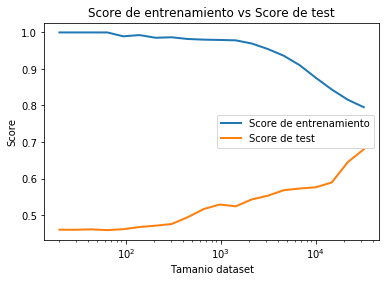

---------------------------------------------------
Clasificador: Arbol de decision


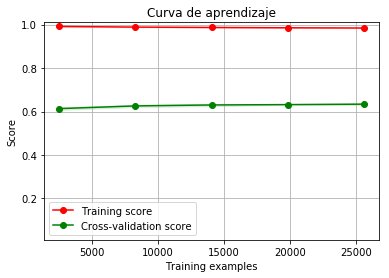

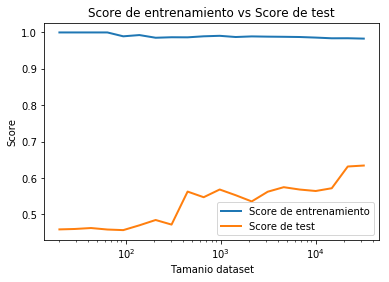

---------------------------------------------------


In [62]:
from sklearn.model_selection import ShuffleSplit
# Igual que en c) y e) 
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2)) #TfidfVectorizer(min_df = 3)  
train_X = vectorizer.fit_transform(df_train.content_pre)
test_X = vectorizer.transform(df_test.content_pre)
train_y = df_train.sentiment_bi
test_y = df_test.sentiment_bi

import matplotlib.pyplot as plt
clf_list = [(MultinomialNB(),"Multinomial Naive Bayes"),
            (LogisticRegression(), "Logistic Regression"),
            (SVC(),"SVM"), 
            (LinearSVC(),"Linear SVM"), 
            (DecisionTreeClassifier(),"Arbol de decision")]

title = "Curva de aprendizaje"
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    plot_learning_curve(clf, title, train_X, train_y, ylim=(0.01, 1.01), cv=cv, n_jobs=4)
    plt.show()
    response = data_size_response(clf,train_X,test_X,train_y,test_y)
    plot_response(*response)
    print "---------------------------------------------------"


De la curva de aprendizaje se tiene que si estas no convergen a 'training score' signigica que hay over-fitting (Arboles de decision), mientras que si convergen a un valor bajo significa que se utilizo un modelo con alto bias (SVM), el resto de los modelos tiene un 'accuracy' de entre 0.69 y 0.71.

In [130]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy: %f"%(acc_tr)
    print "Test Accuracy: %f"%(acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=["+1","-1"]))
clf_list_fitted = [(clf_mnb,"Multinomial Naive Bayes"), 
                   (clf_logreg, "Logistic Regression"),
                   (clf_svc,"SVM"),
                   (clf_lsvc,"Linear SVM"),
                   (clf_ad,"Arbol de decision")]
for clf, clf_name in clf_list_fitted:
    print "Clasificador: {}".format(clf_name)
    score_the_model(clf, train_X_tfidf, df_train.sentiment_bi, test_X, df_test.sentiment_bi)
    print "---------------------------------------------------"

Clasificador: Multinomial Naive Bayes
Training Accuracy: 0.759714
Test Accuracy: 0.688187
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.68      0.60      0.64      3666
         -1       0.69      0.76      0.73      4343

avg / total       0.69      0.69      0.69      8009

---------------------------------------------------
Clasificador: Logistic Regression
Training Accuracy: 0.768435
Test Accuracy: 0.698052
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.69      0.61      0.65      3666
         -1       0.70      0.77      0.73      4343

avg / total       0.70      0.70      0.70      8009

---------------------------------------------------
Clasificador: SVM
Training Accuracy: 0.544122
Test Accuracy: 0.542208
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         +1       0.00      0.00      0.00      3666

"Classification report" entrega los valores de precision, recall y f1-score. Recall es el ritmo verdaderos positivos, es decir, la fraccion de valores positivos obtenidos de forma correcta de entre todos los valores verdaderos positivos (tp/(tp+fn)), precision es la fraccion de verdaderos positivos de entre todos los valores positivos predichos (tp/(tp+fp)), f1-score es un promedio harmónico de precision y recall, es una medida de exactitud.

In [131]:
from sklearn import metrics
for clf, clf_name in clf_list_fitted:
    print "Clasificador: {}".format(clf_name)
    print(metrics.confusion_matrix(df_test.sentiment_bi, clf.predict(test_X)))
    print "---------------------------------------------------"
# tn fp
# fn tp
# fp error tipo 1
# fn error tipo 2

Clasificador: Multinomial Naive Bayes
[[2207 1459]
 [1038 3305]]
---------------------------------------------------
Clasificador: Logistic Regression
[[2238 1428]
 [ 990 3353]]
---------------------------------------------------
Clasificador: SVM
[[   0 3666]
 [   0 4343]]
---------------------------------------------------
Clasificador: Linear SVM
[[2218 1448]
 [1114 3229]]
---------------------------------------------------
Clasificador: Arbol de decision
[[2188 1478]
 [1408 2935]]
---------------------------------------------------


In [132]:
def clf_multi(model, x_train, y_train, x_test, y_test):
    #vec_clf = Pipeline([('vectorizer', vec), ('pac', model)])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print "Training Accuracy: %f"%(model.score(x_train, y_train))
    print "Test Accuracy: %f"%(model.score(x_test, y_test))
    print sklearn.metrics.classification_report(y_test, y_pred)

Se repite el proceso de entrenamiento pero para clasificacion multiclase, con algunos modelos distintos. Las clases del dataframe corresponde a las 13 emociones enumeradas del 0 al 12.

In [65]:
import operator
sentimientos_cod_sorted = sorted(sentimientos_cod.items(), key=lambda x: x[1])
print sentimientos_cod_sorted

[('empty', 0), ('sadness', 1), ('enthusiasm', 2), ('neutral', 3), ('worry', 4), ('surprise', 5), ('love', 6), ('fun', 7), ('hate', 8), ('happiness', 9), ('boredom', 10), ('relief', 11), ('anger', 12)]


In [133]:
import sklearn.metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier

clf_list = [(MultinomialNB(), "Multinomial Naive Bayes"),
            (BernoulliNB(alpha=.01), "Bernoull Naive Bayes"),
            (NearestCentroid(), "NearestCentroid"),
            (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
            (DecisionTreeClassifier(), "Arbol de decision")]
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    clf_multi(clf, train_X, train_y, test_X, test_y)
    print "---------------------------------------------------"

Clasificador: Multinomial Naive Bayes
Training Accuracy: 0.433716
Test Accuracy: 0.324135
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       176
          1       0.34      0.12      0.18       996
          2       0.00      0.00      0.00       159
          3       0.30      0.60      0.40      1696
          4       0.31      0.56      0.40      1710
          5       0.00      0.00      0.00       439
          6       0.56      0.28      0.38       800
          7       0.00      0.00      0.00       360
          8       0.00      0.00      0.00       283
          9       0.36      0.25      0.30      1022
         10       0.00      0.00      0.00        36
         11       0.00      0.00      0.00       306
         12       0.00      0.00      0.00        26

avg / total       0.27      0.32      0.27      8009

---------------------------------------------------
Clasificador: Bernoull Naive Bayes
Training Accuracy: 0.5665

Clasificador: Multinomial Naive Bayes


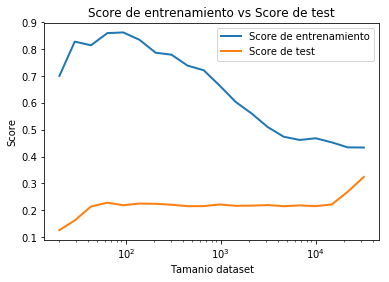

Clasificador: Bernoull Naive Bayes


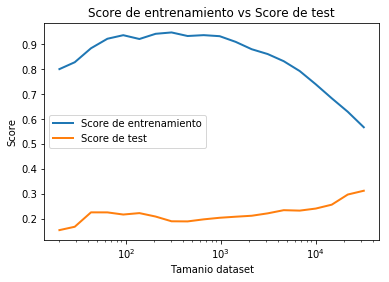

Clasificador: NearestCentroid


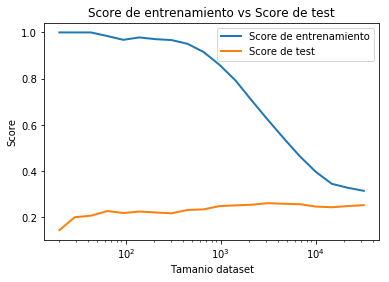

Clasificador: Ridge Classifier


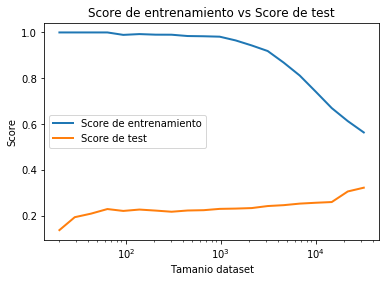

Clasificador: Arbol de decision


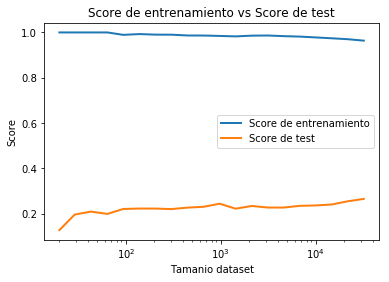

In [134]:
for clf, clf_name in clf_list:
    print "Clasificador: {}".format(clf_name)
    response = data_size_response(clf,train_X,test_X,train_y,test_y)
    plot_response(*response)

Se obtienen 'scores' mucho menores al caso de clasificacion binaria, sin embargo es esperable dado que se trata de 13 clases. De los gráficos se observa que muchos de los modelos presentan over-fitting, esto se podria solucionar al obtener mas muestras de entrenamiento o incrementando los parametros de regularizacion de los modelos. <br>
Cabe notar que el clasificador Multinomial Naive Bayes ignora por completo las clases con menor cantidad de textos asociados, y predice solamente las 5 clases con mayor ocurrencia.

In [135]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
clf_list = [(SGDClassifier(),"SGDClassifier"),
            (LogisticRegression(), "Logistic Regression"), 
            (LinearSVC(),"Linear SVM")]
for clf, clf_name in clf_list:
    clf_oo = OneVsOneClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_oo.score(train_X, train_y)
    clf_score_test = clf_oo.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

SGDClassifier score: Train: 0.504298083836 Test: 0.349356973405
Logistic Regression score: Train: 0.454315276171 Test: 0.349356973405
Linear SVM score: Train: 0.652714826045 Test: 0.325009364465


In [136]:
from sklearn.multiclass import OneVsRestClassifier
for clf, clf_name in clf_list:
    clf_or = OneVsRestClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_or.score(train_X, train_y)
    clf_score_test = clf_or.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

SGDClassifier score: Train: 0.549435778813 Test: 0.302409788987
Logistic Regression score: Train: 0.474539714295 Test: 0.354725933325
Linear SVM score: Train: 0.627051358194 Test: 0.311399675365


In [137]:
lr_list = ((OneVsRestClassifier(LogisticRegression(multi_class="ovr")), "LR extendida OvsR"),
           (LogisticRegression(multi_class="multinomial", solver="newton-cg"), "LR extendida multinomial"))
for lr, lr_name in lr_list:
    clf = lr.fit(train_X, train_y)
    clf_score_train = clf.score(train_X, train_y)
    clf_score_test = clf.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(lr_name, clf_score_train, clf_score_test)

LR extendida OvsR score: Train: 0.474539714295 Test: 0.354725933325
LR extendida multinomial score: Train: 0.490356662811 Test: 0.351854164065


Se tiene que clasificadores extendidos por OneVsOne o OneVsRest no presentan grandes diferencias respecto a los resultados obtenidos al ser comparados con clasificadores multiclase, otra forma de decirlo es que los métodos para extender clasificadores binarios producen resultados similares a los clasificadores multiclase.

In [138]:
clf_list_multi = [(MultinomialNB(), "Multinomial Naive Bayes"),
                  (BernoulliNB(alpha=.01), "Bernoull Naive Bayes"),
                  (NearestCentroid(), "NearestCentroid"),
                  (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
                  (DecisionTreeClassifier(), "Arbol de decision")]

clf_list_ext = [(SGDClassifier(),"SGDClassifier"),
                (LogisticRegression(), "Logistic Regression"),
                (LinearSVC(),"Linear SVM")]

print "Multiclase: "
for clf, clf_name in clf_list_multi:
    clf = clf.fit(train_X, train_y)
    clf_score_train = clf.score(train_X, train_y)
    clf_score_test = clf.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)
    
print "---------------------------------------------------" 

print "Extendidos por One vs One: "
for clf, clf_name in clf_list_ext:
    clf_oo = OneVsOneClassifier(clf).fit(train_X, train_y)
    clf_score_train = clf_oo.score(train_X, train_y)
    clf_score_test = clf_oo.score(test_X, test_y)
    print '{} score: Train: {} Test: {}'.format(clf_name, clf_score_train, clf_score_test)

Multiclase: 
Multinomial Naive Bayes score: Train: 0.43371573255 Test: 0.324135347734
Bernoull Naive Bayes score: Train: 0.566534337783 Test: 0.311774253964
NearestCentroid score: Train: 0.314994842299 Test: 0.253090273442
Ridge Classifier score: Train: 0.563002094339 Test: 0.322262454738
Arbol de decision score: Train: 0.963771060611 Test: 0.265326507679
---------------------------------------------------
Extendidos por One vs One: 
SGDClassifier score: Train: 0.504673189335 Test: 0.350230990136
Logistic Regression score: Train: 0.454315276171 Test: 0.349356973405
Linear SVM score: Train: 0.652714826045 Test: 0.325009364465


Los clasificadores binarios extendidos por otros métodos (OneVsOne) obtienen mejores resultados que aquellos extendidos por defecto